In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Установим красивые дефолтные настройки
### Может быть лень постоянно прописывать
### У графиков параметры цвета, размера, шрифта
### Можно положить их в словарь дефолтных настроек

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

### Decision Trees: практика
### Corporación Favorita Grocery Sales Forecasting

<div>
<img src="picture.png" width="1000"/>
</div>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

In [4]:
df = pd.read_csv('cut_market_info.csv')

df

,date,store_nbr,item_nbr,unit_sales,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred
0,2016-10-26,6,1489881,6.000,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
1,2014-06-02,9,953609,7.000,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
2,2017-06-18,21,1946155,5.000,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
3,2016-07-09,46,119023,6.000,0.0,2016-07,45.37,Quito,Pichincha,A,14,CLEANING,3026,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
4,2016-08-04,43,760319,7.707,0.0,2016-08,41.92,Esmeraldas,Esmeraldas,E,10,POULTRY,2416,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191917,2015-08-25,17,220432,10.000,0.0,2015-08,39.15,Quito,Pichincha,C,12,GROCERY I,1080,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
191918,2014-07-03,30,890375,5.000,0.0,2014-07,104.76,Guayaquil,Guayas,C,3,GROCERY I,1002,0,Holiday,Local,El Carmen,Cantonizacion de El Carmen,Holiday
191919,2014-08-13,44,795610,38.000,0.0,2014-08,97.57,Quito,Pichincha,A,5,FROZEN FOODS,2220,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
191920,2013-10-01,34,213788,3.000,NaN,2013-10,102.09,Guayaquil,Guayas,B,6,GROCERY I,1096,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay


In [5]:
X = df.drop("unit_sales", axis=1)
y = df["unit_sales"]

### Будем считать MSLE

y = y.apply(np.log1p)

### Отделим валидацию от теста по времени!

X_test, X_train = X[X.date >= '2017-06-01'], X[X.date < '2017-06-01']

y_test, y_train = y[y.index.isin(X_test.index)], y[y.index.isin(X_train.index)]

### Уберем колонку с датой

X_test = X_test.drop('date', axis=1)
X_train = X_train.drop('date', axis=1)
X = X.drop('date', axis=1)

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X[object_cols] = X[object_cols].astype(object)
X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)

X.head()

,store_nbr,item_nbr,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred
0,6,1489881,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
1,9,953609,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
2,21,1946155,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
3,46,119023,0.0,2016-07,45.37,Quito,Pichincha,A,14,CLEANING,3026,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
4,43,760319,0.0,2016-08,41.92,Esmeraldas,Esmeraldas,E,10,POULTRY,2416,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay


In [6]:
from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit(n_splits=3)

### Дерево

In [7]:
### Кастомные трансформеры - это круто, 
### но на больших данных необходимо задумываться
### об оптимизации и векторных вычислениях
### Будем трансформировать колонки уже готовыми реализациями


In [7]:
!pip install category-encoders


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
### Запишем заранее колонки для OHE
### и счетчиков
### а также вещественные колонки


cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [11]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [12]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), [2, 11, 13]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [0, 1, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16]),
                                ('StandardScaler', StandardScaler(), [4])])

In [13]:
col_transform.transform(X_test)

array([[ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.73037563],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.68616989],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.60849999],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.67708086],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.68616989],
       [ 0.        ,  1.        ,  0.        , ...,  1.74964584,
         1.74964584, -0.56181542]])

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeRegressor())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 5, 6, 7, 8, 9, 10,
                                                   12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(), [4])])),
                ('decision_tree', DecisionTreeRegressor())])

In [15]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.0
Качество на тесте: 0.832


In [16]:
### Попробуем контролировать обобщающую способность такой модели!

from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 10],
    "decision_tree__min_samples_split": [10, 200, 50000],
    "decision_tree__min_impurity_decrease": [0, 0.1],
    "decision_tree__max_leaf_nodes": [100, 1000]
}

### Передадим в GridSearchCV

search = GridSearchCV(pipe_dt, 
                      param_grid, 
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.536 total time=   0.9s
[CV 2/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.513 total time=   1.6s
[CV 3/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nod

[CV 2/3; 16/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.623 total time=   1.7s
[CV 3/3; 16/36] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 3/3; 16/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.629 total time=   2.5s
[CV 1/3; 17/36] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=200
[CV 1/3; 17/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=200;, score=-0.637 total time=   1.0s
[CV 2/3; 17/36] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, de

[CV 1/3; 24/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50000;, score=-0.779 total time=   0.9s
[CV 2/3; 24/36] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50000
[CV 2/3; 24/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50000;, score=-0.623 total time=   1.6s
[CV 3/3; 24/36] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50000
[CV 3/3; 24/36] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50000;, score=-0.629 total time=   2.5s
[CV 1/3; 25/36] START decision_tree__max_depth=10, decision_tree__max

[CV 3/3; 31/36] END decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.464 total time=   3.0s
[CV 1/3; 32/36] START decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=200
[CV 1/3; 32/36] END decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=200;, score=-0.492 total time=   1.1s
[CV 2/3; 32/36] START decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=200
[CV 2/3; 32/36] END decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=200;, score=-0.466 total time=   2.0s
[CV 3/3; 32/36] START decision_tree__max_depth=10, decision_tree__max_leaf_nodes=1000

### Обучение стекинга

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                  
                    ("decision_tree", 
                     DecisionTreeRegressor())])

pipe_lr = Pipeline([("column_transformer",
                     col_transform),
                  
                    ("Lasso", 
                     Lasso())])

pipe_knn = Pipeline([("column_transformer",
                      col_transform),

                     ("knn", 
                      KNeighborsRegressor())])
 
estimators = [
    ("dt", pipe_dt),
    ("lr", pipe_lr),
    ("knn", pipe_knn)
]

final_estimator = DecisionTreeRegressor(max_depth=3)

### Base learners are fitted on the full X
### while the final estimator is trained
### using cross-validated predictions of the base learners
### using cross_val_predict.

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=2
)

In [18]:
stacking_model.fit(X_train, y_train)

StackingRegressor(cv=2,
                  estimators=[('dt',
                               Pipeline(steps=[('column_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  5,
                                                                                  6,
                                                                                  7,
                                                                                  8,
                                                                                  9,
                                                                                  10,
                                                                                  12,
                                                                                  14,
                                                                                  15,
                                                                                  16]),
                                                                                ('StandardScaler',
                                                                                 StandardScaler(),
                                                                                 [4])])),
                                               ('decision_tree',
                                                DecisionTreeRegressor())])),
                              ('lr',
                               Pipeline(steps=[('column_trans...
                                                                                 StandardScaler(),
                                                                                 [4])])),
                                               ('Lasso', Lasso())])),
                              ('knn',
                               Pipeline(steps=[('column_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  5,
                                                                                  6,
                                                                                  7,
                                      

In [19]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = stacking_model.predict(X_train)
test_preds = stacking_model.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.36
Качество на тесте: 0.505


### Обучение бэггинга

In [20]:
from sklearn.ensemble import BaggingRegressor

base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("decision_tree", 
                      DecisionTreeRegressor(max_depth=10))])

bagging = BaggingRegressor(base_estimator=base_pipe,
                            n_estimators=10, random_state=32)

bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                  OneHotEncoder(),
                                                                                  [2,
                                                                                   11,
                                                                                   13]),
                                                                                 ('MeanTargetEncoder',
                                                                                  TargetEncoder(),
                                                                                  [0,
                                                                                   1,
                                                                                   3,
                                                                                   5,
                                                                                   6,
                                                                                   7,
                                                                                   8,
                                                                                   9,
                                                                                   10,
                                                                                   12,
                                                                                   14,
                                                                                   15,
                                                                                   16]),
                                                                                 ('StandardScaler',
                                                                                  StandardScaler(),
                                                                                  [4])])),
                                                ('decision_tree',
                                                 DecisionTreeRegressor(max_depth=10))]),
                 random_state=32)

In [21]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.392
Качество на тесте: 0.447


In [22]:
### Построим обучающие кривые:

train_losses = []
test_losses = []

for i in range(1, 21):
    
    bagging = BaggingRegressor(base_estimator=base_pipe,
                               n_estimators=i, random_state=32)

    bagging.fit(X_train, y_train)
    
    train_preds = bagging.predict(X_train)
    test_preds = bagging.predict(X_test)

    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)

    train_losses.append(train_error)
    test_losses.append(test_error)

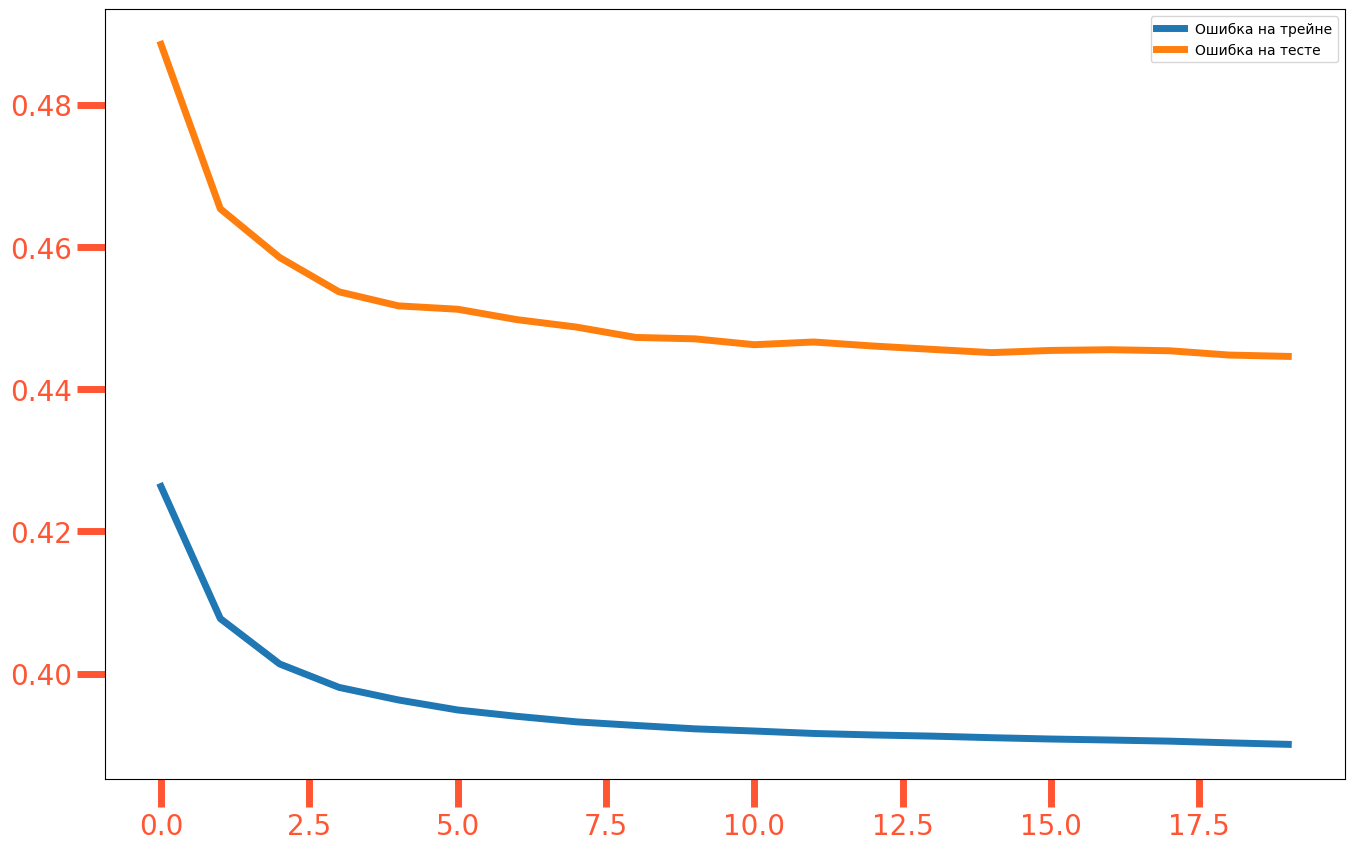

In [23]:
fig = plt.figure()
fig.set_size_inches(16, 10)

plt.plot(train_losses)
plt.plot(test_losses)

plt.legend(['Ошибка на трейне', 'Ошибка на тесте'])
plt.show()

### RandomForest

In [24]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("decision_tree", 
                               RandomForestRegressor(max_depth=10,
                                                     verbose=1))])

RandomForest_pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.1s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 5, 6, 7, 8, 9, 10,
                                                   12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(), [4])])),
                ('decision_tree',
                 RandomForestRegressor(max_depth=10, verbose=1))])

In [25]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = RandomForest_pipe.predict(X_train)
test_preds = RandomForest_pipe.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


Качество на трейне: 0.39
Качество на тесте: 0.447


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [63]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 3)]
max_depth = [int(x) for x in np.linspace(10, 51, num = 4)]


param_grid =  {'decision_tree__n_estimators': n_estimators,
               'decision_tree__max_depth': max_depth
              }

### Передадим в GridSearchCV

search = GridSearchCV(RandomForest_pipe, 
                      param_grid, 
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 1/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.473 total time=   6.3s
[CV 2/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 2/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.449 total time=  12.5s
[CV 3/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 3/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.440 total time=  20.4s
[CV 1/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.8s finished


[CV 1/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.472 total time=  25.5s
[CV 2/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   48.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.8s finished


[CV 2/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.448 total time=  50.7s
[CV 3/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.8s finished


[CV 3/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.440 total time= 1.3min
[CV 1/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   43.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.4s finished


[CV 1/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.472 total time=  45.9s
[CV 2/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished


[CV 2/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.448 total time= 1.6min
[CV 3/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished


[CV 3/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.440 total time= 2.4min
[CV 1/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


[CV 1/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.480 total time=  12.1s
[CV 2/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


[CV 2/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.448 total time=  26.5s
[CV 3/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   36.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


[CV 3/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.433 total time=  39.6s
[CV 1/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.2s finished


[CV 1/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.474 total time=  54.5s
[CV 2/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.6s finished


[CV 2/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.442 total time= 1.9min
[CV 3/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.9s finished


[CV 3/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.428 total time= 3.0min
[CV 1/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.2s finished


[CV 1/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.473 total time= 1.7min
[CV 2/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.0s finished


[CV 2/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.442 total time= 3.6min
[CV 3/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.4s finished


[CV 3/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.427 total time= 5.4min
[CV 1/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


[CV 1/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.483 total time=  14.4s
[CV 2/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


[CV 2/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.452 total time=  30.0s
[CV 3/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   43.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


[CV 3/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.436 total time=  46.9s
[CV 1/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   58.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.5s finished


[CV 1/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.475 total time= 1.0min
[CV 2/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.7s finished


[CV 2/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.444 total time= 2.1min
[CV 3/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    3.1s finished


[CV 3/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.430 total time= 3.1min
[CV 1/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.2s finished


[CV 1/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.475 total time= 1.7min
[CV 2/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.3s finished


[CV 2/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.444 total time= 3.5min
[CV 3/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    6.4s finished


[CV 3/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.429 total time= 5.5min
[CV 1/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


[CV 1/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.482 total time=  13.5s
[CV 2/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   25.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


[CV 2/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.451 total time=  27.9s
[CV 3/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   39.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


[CV 3/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.437 total time=  43.1s
[CV 1/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   51.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.2s finished


[CV 1/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.475 total time=  55.3s
[CV 2/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    2.8s finished


[CV 2/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.445 total time= 2.0min
[CV 3/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    3.2s finished


[CV 3/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.430 total time= 3.1min
[CV 1/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.2s finished


[CV 1/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.475 total time= 1.7min
[CV 2/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.7s finished


[CV 2/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.444 total time= 3.5min
[CV 3/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.5s finished


[CV 3/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.429 total time= 5.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameter (CV score=-0.44752):
{'decision_tree__max_depth': 23, 'decision_tree__n_estimators': 400}
Качество лучшей модели на финальном тесте: -0.43595517851945503


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.3s finished


### Укорочение ряда и выделение новых фичей: трюки победителей

In [5]:
### Грузим часть данных после 2017-01-01

df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_train = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]

### Для каждого (товар-магазин) на каждый день составим продажи

df_2017 = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [6]:
df_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10  2017-01-11  2017-01-12  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.000000    0.693147    0.000000    0.000000   
          103520      0.693147    0.693147    0.000000    0.000000   
          103665      0.000000    2.079442    0.693147    0.693147   
          105574      1.386294    2.302585    2.484907    1.386294   

date                2017-01-13  2017-01-14  2017-01-15  2017-01-16  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.000000    1.098612    0.693147    0.000000   
          103520      0.693147    0.000000    1.098612    1.098612   
          103665      2.079442    0.000000    0.000000    1.098612   
          105574      1.098612    1.386294    0.000000    1.609438   

date                2017-01-17  2017-01-18  2017-01-19  2017-01-20  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.000000    0.000000    1.098612    0.000000   
          103520      0.000000    1.098612    0.693147    1.386294   
          103665      0.693147    1.791759    1.386294    1.098612   
          105574      2.397895    2.197225    2.639057    1.609438   

date                2017-01-21  2017-01-22  2017-01-23  2017-01-24  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       1.386294    0.693147    0.000000    0.000000   
          103520      1.609438    0.000000    0.000000    0.693147   
          103665      1.609438    1.098612    1.386294    1.098612   
          105574      1.609438    1.098612    2.079442    1.945910   

date                2017-01-25  2017-01-26  2017-01-27  2017-01-28  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.000000    0.000000    0.000000    0.693147   
          103520      1.098612    0.693147    1.098612    0.000000   
          103665      1.098612    1.098612    1.945910    1.945910   
          105574      1.945910    2.079442    2.484907    1.609438   

date                2017-01-29  2017-01-30  2017-01-31  2017-02-01  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.000000    0.000000    0.000000   
          103520      0.000000    0.000000    0.693147    1.098612   
          103665      0.000000    0.000000    0.693147    0.693147   
          105574      0.693147    2.197225    1.791759    2.079442   

date                2017-02-02  2017-02-03  2017-02-04  2017-02-05  \
st

In [7]:
### Аналогично можно посмотреть на наличие промо-акций

promo_2017 = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

promo_2017.columns = promo_2017.columns.get_level_values(1)

In [8]:
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False        True       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False        True       False       False   

date                2017-01-09  2017-01-10  2017-01-11  2017-01-12  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-01-13  2017-01-14  2017-01-15  2017-01-16  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-01-17  2017-01-18  2017-01-19  2017-01-20  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-01-21  2017-01-22  2017-01-23  2017-01-24  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-01-25  2017-01-26  2017-01-27  2017-01-28  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-01-29  2017-01-30  2017-01-31  2017-02-01  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False        True   

date                2017-02-02  2017-02-03  2017-02-04  2017-02-05  \
st

In [9]:
from datetime import date, timedelta

def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

control_date = date(2017, 5, 1)

get_timespan(df_2017, control_date, 5, 5)

date                2017-04-26  2017-04-27  2017-04-28  2017-04-29  2017-04-30
store_nbr item_nbr                                                            
1         96995       0.693147    0.000000    0.693147    0.000000    0.000000
          99197       0.000000    0.000000    0.000000    0.000000    0.000000
          103520      0.000000    1.098612    1.098612    1.386294    0.000000
          103665      1.386294    1.386294    1.609438    1.386294    0.000000
          105574      1.791759    2.397895    2.079442    1.945910    1.098612
...                        ...         ...         ...         ...         ...
54        2109909     0.000000    0.000000    0.000000    0.000000    0.000000
          2110456     0.000000    0.000000    0.000000    0.000000    0.000000
          2113343     0.000000    0.000000    0.000000    0.000000    0.000000
          2113914     0.000000    0.000000    0.000000    0.000000    0.000000
          2116416     0.000000    0.000000    0.000000    0.000000    0.000000

[167515 rows x 5 columns]

In [10]:
### Например, можно выбрать какую-то контрольную дату
### Посчитать от нее для каждой пары товар-магазин
### Количество дней, когда были ненулевые продажи

tmp = get_timespan(df_2017, control_date, 7, 7)

(tmp > 0).sum(axis=1)

store_nbr  item_nbr
1          96995       2
           99197       0
           103520      4
           103665      5
           105574      7
                      ..
54         2109909     0
           2110456     0
           2113343     0
           2113914     0
           2116416     0
Length: 167515, dtype: int64

In [11]:
### Или количество дней из последних n штук
### Когда проводилась промо-акция на пару товар-магазин
### От выбранной даты

tmp = get_timespan(promo_2017, control_date, 60, 60)

tmp.sum(axis=1)

store_nbr  item_nbr
1          96995        0
           99197        0
           103520       0
           103665       0
           105574      30
                       ..
54         2109909      0
           2110456      0
           2113343      0
           2113914      0
           2116416      0
Length: 167515, dtype: int64

In [12]:
def prepare_dataset(df, promo_df, t2017, name_prefix=None):
    
    ### Посчитаем количество промо-акцкий за последние 
    ### 14, 60, 140 дней от контрольной даты
    
    X = {
        "promo_14_2017": get_timespan(promo_df, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_df, t2017, 60, 60).sum(axis=1).values,
    }

    ### Посчитаем для разного окна
    ### Различные статистики по продажам
    ### Среднее изменение продаж от дня к дню, 
    ### Медианы продаж, максимальные и минимальные значения,
    ### Взвешенные средние и т.д.
    
    for i in [3, 7, 14, 30, 60]:
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values
        
    ### Посчитаем аналогичные статистики
    ### Только для даты, на неделю раньше,
    ### Чем контрольная
    
    for i in [3, 7, 14, 30, 60]:
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values

    ### Посчитаем фичи, описывающие
    ### Количество дней ненулевых продаж за выбранный период
    ### Дни с первой и последней продажи
    ### И аналогичные статистики по промо-акциям
    
    for i in [7, 14, 30, 60]:
        tmp = get_timespan(df, t2017, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

        tmp = get_timespan(promo_df, t2017, i, i)
        X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    X = pd.DataFrame(X)
    
    return X

In [13]:
new_features = prepare_dataset(df_2017, promo_2017, control_date)

new_features.index = promo_2017.index

new_features

promo_14_2017  promo_60_2017  diff_3_mean  mean_3_decay  \
store_nbr item_nbr                                                            
1         96995                 0              0    -0.346574      0.561449   
          99197                 0              0     0.000000      0.000000   
          103520                0              0    -0.549306      2.137541   
          103665                0              0    -0.804719      2.551310   
          105574                6             30    -0.490415      4.534279   
...                           ...            ...          ...           ...   
54        2109909               0              0     0.000000      0.000000   
          2110456               0              0     0.000000      0.000000   
          2113343               0              0     0.000000      0.000000   
          2113914               0              0     0.000000      0.000000   
          2116416               0              0     0.000000      0.000000   

                      mean_3  median_3     min_3     max_3     std_3  \
store_nbr item_nbr                                                     
1         96995     0.231049  0.000000  0.000000  0.693147  0.400189   
          99197     0.000000  0.000000  0.000000  0.000000  0.000000   
          103520    0.828302  1.098612  0.000000  1.386294  0.731610   
          103665    0.998577  1.386294  0.000000  1.609438  0.871961   
          105574    1.707988  1.945910  1.098612  2.079442  0.531941   
...                      ...       ...       ...       ...       ...   
54        2109909   0.000000  0.000000  0.000000  0.000000  0.000000   
          2110456   0.000000  0.000000  0.000000  0.000000  0.000000   
          2113343   0.000000  0.000000  0.000000  0.000000  0.000000   
          2113914   0.000000  0.000000  0.000000  0.000000  0.000000   
          2116416   0.000000  0.000000  0.000000  0.000000  0.000000   

                    diff_7_mean  mean_7_decay    mean_7  median_7     min_7  \
store_nbr item_nbr                                                            
1         96995        0.000000      1.016223  0.198042  0.000000  0.000000   
          99197        0.000000      0.000000  0.000000  0.000000  0.000000   
          103520      -0.268240      3.793751  0.741851  1.098612  0.000000   
          103665       0.000000      4.880762  0.923067  1.386294  0.000000   
          105574      -0.216547     10.091911  2.002014  2.079442  1.098612   
...                         ...           ...       ...       ...       ...   
54        2109909      0.000000      0.000000  0.000000  0.000000  0.000000   
          2110456      0.000000      0.000000  0.000000  0.000000  0.000000   
          2113343      0.000000      0.000000  0.000000  0.000000  0.000000   
          2113914      0.000000      0.000000  0.000000  0.000000  0.000000   
          2116416      0.000000      0.000000  0.000000  0.000000  0.000000   

                       max_7     std_7  diff_14_mean  mean_14_decay   mean_14  \
store_nbr item_nbr                                                              
1         96995     0.693147  0.338221     -0.053319       2.214791  0.326025   
          99197     0.000000  0.000000      0.000000       0.000000  0.000000   
          103520    1.609438  0.715728     -0.084509       6.473794  0.923954   
          103665    1.609438  0.691835     -0.106638       7.981246  1.093034   
          105574    2.397895  0.460665     -0.075448      13.735860  1.776430   
...                      ...       ...           ...            ...       ...   
54        2109909   0.000000  0.000000      0.000000       0.000000  0.000000   
          2110456   0.000000  0.000000      0.000000       0.000000  0.000000   
          2113343   0.000000  0.000000      0.000000       0.000000  0.000000   
          2113914   0.000000  0.000000      0.000000       0.000000  0.000000   
          2116416   0.000000  0.000000      0.000000   

In [14]:
### Вернемся к нашей задаче

X = df.drop("unit_sales", axis=1)
y = df["unit_sales"]

### Будем считать MSLE

y = y.apply(np.log1p)

### Добавим новые фичи 

New_X = pd.merge(X,
                 new_features.reset_index(),
                 on=['store_nbr', 'item_nbr'],
                 how='left'
                )

New_X.head()

,date,store_nbr,item_nbr,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred,promo_14_2017,promo_60_2017,diff_3_mean,mean_3_decay,mean_3,median_3,min_3,max_3,std_3,diff_7_mean,mean_7_decay,mean_7,median_7,min_7,max_7,std_7,diff_14_mean,mean_14_decay,mean_14,median_14,min_14,max_14,std_14,diff_30_mean,mean_30_decay,mean_30,median_30,min_30,max_30,std_30,diff_60_mean,mean_60_decay,mean_60,median_60,min_60,max_60,std_60,diff_3_mean_2,mean_3_decay_2,mean_3_2,median_3_2,min_3_2,max_3_2,std_3_2,diff_7_mean_2,mean_7_decay_2,mean_7_2,median_7_2,min_7_2,max_7_2,std_7_2,diff_14_mean_2,mean_14_decay_2,mean_14_2,median_14_2,min_14_2,max_14_2,std_14_2,diff_30_mean_2,mean_30_decay_2,mean_30_2,median_30_2,min_30_2,max_30_2,std_30_2,diff_60_mean_2,mean_60_decay_2,mean_60_2,median_60_2,min_60_2,max_60_2,std_60_2,has_sales_days_in_last_7,last_has_sales_day_in_last_7,first_has_sales_day_in_last_7,has_promo_days_in_last_7,last_has_promo_day_in_last_7,first_has_promo_day_in_last_7,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_promo_days_in_last_14,last_has_promo_day_in_last_14,first_has_promo_day_in_last_14,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_promo_days_in_last_30,last_has_promo_day_in_last_30,first_has_promo_day_in_last_30,has_sales_days_in_last_60,last_has_sales_day_in_last_60,first_has_sales_day_in_last_60,has_promo_days_in_last_60,last_has_promo_day_in_last_60,first_has_promo_day_in_last_60
0,2016-10-26,6,1489881,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay,0.0,4.0,0.745046,8.883628,3.224775,2.772589,2.639057,4.262680,0.901328,0.710447,10.399541,1.679110,2.079442,0.000000,4.262680,1.703454,0.327898,12.005771,1.182111,0.000000,0.000000,4.262680,1.495706,0.018935,14.843954,1.363939,1.589027,0.0,4.262680,1.392792,4.497020e-02,15.442754,1.318462,1.098612,0.0,4.262680,1.323773,-1.198948,1.942295,0.799298,0.000000,0.000000,2.397895,1.384425,0.000000,3.358228,0.685113,0.000000,0.000000,2.397895,1.170053,0.000000,7.860521,1.245464,1.098612,0.0,2.995732,1.303519,-0.106588,9.918927,1.333189,1.589027,0.0,3.713572,1.330309,-0.049906,10.587129,1.387854,1.497866,0.0,3.713572,1.279725,4.0,1.0,4.0,0.0,7.0,0.0,6.0,1.0,13.0,0.0,14.0,0.0,16.0,1.0,30.0,2.0,19.0,26.0,34.0,1.0,60.0,4.0,19.0,40.0
1,2014-06-02,9,953609,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay,13.0,47.0,0.346574,3.195409,1.155245,1.386294,0.693147,1.386294,0.400189,0.047947,6.900844,1.362023,1.386294,0.693147,2.890372,0.741821,0.022129,9.971839,1.274331,1.242453,0.000000,2.890372,0.654246,-0.019297,11.574962,1.173560,1.242453,0.0,2.890372,0.667977,7.526936e-18,11.964368,1.099339,1.098612,0.0,2.890372,0.648864,-0.255413,4.014841,1.499937,1.609438,1.098612,1.791759,0.359313,0.000000,6.420688,1.186639,1.098612,0.000000,1.791759,0.599312,0.031190,8.009501,0.948306,1.098612,0.0,1.791759,0.602461,0.037883,10.213282,1.067625,1.098612,0.0,2.197225,0.656955,-0.004876,10.597875,1.016509,1.098612,0.0,2.397895,0.645706,7.0,1.0,7.0,7.0,1.0,7.0,13.0,1.0,14.0,13.0,1.0,14.0,26.0,1.0,30.0,26.0,1.0,30.0,51.0,1.0,60.0,47.0,1.0,56.0
2,2017-06-18,21,1946155,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay,2.0,21.0,-0.040021,6.634842,2.450814,2.484907,2.302585,2.564949,0.134464,-0.025692,11.167831,2.096233,2.302585,1.098612,2.639057,0.561049,0.014025,16.183944,2.018282,1.935601,1.098612,3.091042,0.581641,-0.002760,19.026990,1.769991,2.012676,0.0,3.091042,0.897712,4.211706e-02,19.672146,1.679523,2.012676,0.0,3.091042,0.983105,0.740802,6.266185,2.259974,2.079442,1.609438,3.091042,0.757121,0.131410,10.487446,1.940331,1.791759,1.098612,3.091042,0.635644,0.237772,13.721263,1.521182,1.700599,0.0,3.091042,1.024271,0.018141,17.171013,1.652

In [15]:
## Отделим валидацию от теста по времени!

X_test, X_train = New_X[New_X.date >= '2017-06-01'], New_X[(New_X.date < '2017-06-01')&(New_X.date >= '2017-01-01')]

y_test, y_train = y[y.index.isin(X_test.index)], y[y.index.isin(X_train.index)]

### Уберем колонку с датой

X_test = X_test.drop('date', axis=1)
X_train = X_train.drop('date', axis=1)
New_X = New_X.drop('date', axis=1)

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)

In [18]:
y_test.to_csv('y_test_updated.csv', index=False)
y_train.to_csv('y_train_updated.csv', index=False)

X_test.to_csv('X_test_updated.csv', index=False)
X_train.to_csv('X_train_updated.csv', index=False)

In [144]:
### Запишем заранее колонки для OHE
### и счетчиков
### а также вещественные колонки


cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [149]:
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [150]:
### Зафитим модель на новых данных
### И замерим качество на тесте и на трейне

RandomForest_best_pipe = Pipeline([("column_transformer",
                                    col_transform),
                  
                                   ("decision_tree", 
                                    RandomForestRegressor(max_depth=23,
                                                          n_estimators=500,
                                                          verbose=1))])

RandomForest_best_pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  7.8min finished


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 5, 6, 7, 8, 9, 10,
                                                   12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  [4, 17, 18, 19, 20, 21, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36,
                                                   37, 38, 39, 40, 41, 42, 43,
                          

In [151]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = RandomForest_best_pipe.predict(X_train)
test_preds = RandomForest_best_pipe.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Качество на трейне: 0.043
Качество на тесте: 0.337


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
